In [7]:
import pickle
import os

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import networkx as nx

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("../../src/")

from classifiers.features import get_distances

In [8]:
def D(x, y): return 2*((1/x) / ((1/x) + (1/y))) - 1
def Dprime(x, y): return x/(y + 1e-9)

In [9]:
def get_center_of_mass(vectors):
    return np.mean(vectors, axis=0)

def align_centers(U, V):
    ubar = get_center_of_mass(U)
    vbar = get_center_of_mass(V)

    delta = ubar - vbar

    Vprime = [v + delta for v in V]

    return Vprime

In [16]:
caches = []
features = {}
features_test = {}
for file in os.listdir("../../data/input/preprocessed/"):
    if "london" in file and file.endswith(".pkl"):
        # Load raw data
        with open("../../data/input/preprocessed/" + file, "rb") as _fh:
            data = pickle.load(_fh)
            print("found data")
        caches.append(data)

        # Apply vector processing
        # & Note: r(x) = ax, s(x) = x + b
        # & r(s(x)) = ax + ab != s(r(x)) = ax + b
        ## Renormalize
        data.embeddings = data.renormalize()

        ## Align centers
        for layer in [0, 1]:
            # Retrieve components
            components = sorted([list(c) for c in nx.connected_components(data.remnants[layer])], key=len, reverse=True)

            # Get vectors for each component
            components_vectors = [
                [data.embeddings[layer][node] for node in component]
                for component in components
            ]

            # Align each vector set to GCC center
            shifted_components_vectors = [components_vectors[0]]
            for V in components_vectors[1:]:
                shifted_components_vectors.append(align_centers(components_vectors[0], V))

            # Replace old vector with shifted vector
            for component_id, component_vectors in enumerate(shifted_components_vectors):
                for node_index, shifted_vector in enumerate(component_vectors):
                    data.embeddings[layer][components[component_id][node_index]] = shifted_vector


        # Calculate both feature forms
        distances_G, distances_H = \
            get_distances(data.embeddings, list(data.observed_edges.keys()))
        feature_D = [D(distances_G[idx], distances_H[idx]) for idx in range(len(distances_G))]
        feature_Dprime = [Dprime(distances_G[idx], distances_H[idx]) for idx in range(len(distances_G))]
        labels = list(data.observed_edges.values())

        features[data.theta] = [feature_D, feature_Dprime, labels]

        # Calculate both feature forms for testset
        distances_G, distances_H = \
            get_distances(data.embeddings, list(data.unobserved_edges.keys()))
        feature_D = [D(distances_G[idx], distances_H[idx]) for idx in range(len(distances_G))]
        feature_Dprime = [Dprime(distances_G[idx], distances_H[idx]) for idx in range(len(distances_G))]
        labels = list(data.unobserved_edges.values())

        features_test[data.theta] = [feature_D, feature_Dprime, labels]
    else:
        continue

In [11]:
scores_d = []
scores_dprime = []
aurocs_d = []
aurocs_dprime = []
thetas = []
for theta, features_ in features.items():
    model_d = LogisticRegression(fit_intercept=False)
    model_dprime = LogisticRegression(fit_intercept=False)

    X_d = np.array(features_[0]).reshape(-1,1)
    X_dprime = np.array(features_[1]).reshape(-1,1)
    Y = np.array(features_[2])

    X_d_test = np.array(features_test[theta][0]).reshape(-1,1)
    X_dprime_test = np.array(features_test[theta][1]).reshape(-1,1)
    Y_test = np.array(features_test[theta][2])

    model_d.fit(X_d, Y)
    model_dprime.fit(X_dprime, Y)

    score_d = model_d.predict_proba(X_d_test)[:, 1]
    score_dprime = model_dprime.predict_proba(X_dprime_test)[:, 1]
    auroc_d = roc_auc_score(Y_test, score_d)
    auroc_dprime = roc_auc_score(Y_test, score_dprime)

    thetas.append(theta)
    scores_d.append(score_d)
    scores_dprime.append(score_dprime)
    aurocs_d.append(auroc_d)
    aurocs_dprime.append(auroc_dprime)

Text(0.5, 1.0, 'Comparing feature forms\n O.O.B. N2V with vector renormalization and center alignment')

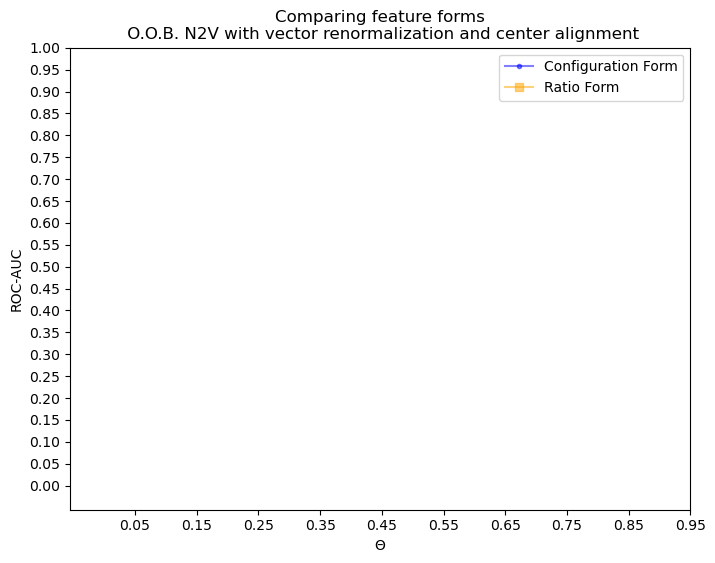

In [12]:
plt.figure(figsize=(8,6))

pts_d = dict(sorted({thetas[x]: aurocs_d[x] for x in range(len(thetas))}.items()))
pts_dprime = dict(sorted({thetas[x]: aurocs_dprime[x] for x in range(len(thetas))}.items()))

plt.plot(
    pts_d.keys(), pts_d.values(),
    label="Configuration Form",
    color="blue", marker=".",
    alpha = 0.5
)
plt.plot(
    pts_dprime.keys(), pts_dprime.values(),
    label="Ratio Form",
    color="orange", marker="s",
    alpha = 0.5
)

plt.legend()
plt.xticks(np.linspace(0.05, 0.95, 10))
plt.yticks(np.linspace(0,1,21))

plt.xlabel("$\\Theta$")
plt.ylabel("ROC-AUC")

plt.title("Comparing feature forms\n O.O.B. N2V with vector renormalization and center alignment")